# Pre-Processing of Data with Stacked, Denoising Autoencoders

In [1]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor

In [2]:
# Check CUDA
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"Current device: {torch.cuda.get_device_name(device)}")
else:
    print("CUDA unavailable :(")

CUDA is available!
Current device: NVIDIA GeForce RTX 3060 Ti


## Data Exploration

In [3]:
with open(os.path.join('..', '..', 'dfdc_train_part_45', 'metadata.json'), 'r', encoding='utf-8') as f:
    metadata = json.load(f)

display(metadata)

{'gthvvygfcj.mp4': {'label': 'FAKE',
  'split': 'train',
  'original': 'lxeqbyddvt.mp4'},
 'yunqitmhjo.mp4': {'label': 'FAKE',
  'split': 'train',
  'original': 'hbrgvmrtnn.mp4'},
 'mwizcjywkd.mp4': {'label': 'FAKE',
  'split': 'train',
  'original': 'stdavraahk.mp4'},
 'ymswdhnnyp.mp4': {'label': 'FAKE',
  'split': 'train',
  'original': 'gwzttezkpv.mp4'},
 'lsfsintfky.mp4': {'label': 'FAKE',
  'split': 'train',
  'original': 'xrtmepdfyh.mp4'},
 'bfkfrtmiub.mp4': {'label': 'FAKE',
  'split': 'train',
  'original': 'bpkpvrqduq.mp4'},
 'ryuocfdklj.mp4': {'label': 'FAKE',
  'split': 'train',
  'original': 'rohuegtohf.mp4'},
 'jrtgsrmvfu.mp4': {'label': 'REAL', 'split': 'train'},
 'xuszvuvabr.mp4': {'label': 'FAKE',
  'split': 'train',
  'original': 'lauifordgs.mp4'},
 'tltyusajlj.mp4': {'label': 'FAKE',
  'split': 'train',
  'original': 'kdhfvtnpik.mp4'},
 'ipouzwmwit.mp4': {'label': 'FAKE',
  'split': 'train',
  'original': 'icbzbcwlgf.mp4'},
 'dbixwxtuxs.mp4': {'label': 'REAL', 'split'

Just to see what this will look like, I'll open the first video present and try to gather some stats on it from OpenCV

In [4]:
# addr = os.path.join('..', '..', 'dfdc_train_part_45', list(metadata.keys())[0])
# vid = cv2.VideoCapture(addr)
# print(f"Address: {addr}")
# print(f"Duration: {vid.get(cv2.CAP_PROP_POS_MSEC)}")
# print(f"Number of frames: {vid.get(cv2.CAP_PROP_FRAME_COUNT)}")

So it appears that the videos are roughly 10 seconds each and that they were shot at 30 FPS, yielding about 300 frames. Let's do a more detailed analysis of the frame counts from all of the videos in the training set (the first 80% of the entries in metadata).

In [5]:
# frame_cts = []

# file_names = list(metadata.keys())

# for i in range(int(0.8 * len(file_names))):
#     frame_cts.append(cv2.VideoCapture(os.path.join('..', '..', 'dfdc_train_part_45', file_names[i])).get(cv2.CAP_PROP_FRAME_COUNT))

In [6]:
# print(f"Min number of frames: {min(frame_cts)}")
# print(f"Max number of frames: {max(frame_cts)}")

## Conversion to Images

Each 10 second video will be converted a series of 10 images (one every 30 frames). These wil be the inputs to the autoencoder.

In [7]:
file_names = list(metadata.keys())

In [8]:
frames_path = os.path.join('..', '..', 'frames')
if not os.path.isdir(frames_path):
    os.mkdir(frames_path)

In [9]:
# Create output directory for train images
train_path = os.path.join('..', '..', 'frames', 'train')
if not os.path.isdir(train_path):
    os.mkdir(train_path)

In [10]:
def gen_frames(output_dir, file_names, range_obj):
    INTERVAL = 30

    for i in range_obj:
        video_filename = file_names[i]
        camera = cv2.VideoCapture(os.path.join('..', '..', 'dfdc_train_part_45', video_filename))

        counter = 0
        while True:
            ret, frame = camera.read()

            if ret:
                if counter % INTERVAL == 0:
                    output_path = os.path.join(output_dir, f'{video_filename}_{counter}.jpg')
                    cv2.imwrite(output_path, frame)
                counter += 1
            else:
                break

In [11]:
# gen_frames(train_path, file_names, range(int(0.8 * len(file_names))))

In [12]:
# len(os.listdir(train_path))

In [13]:
# int(len(metadata) * 0.8)

In [14]:
# os.listdir(train_path)

In [15]:
# Create output directory for validation images
val_path = os.path.join('..', '..', 'frames', 'validation')
if not os.path.isdir(val_path):
    os.mkdir(val_path)

In [16]:
# gen_frames(val_path, file_names, range(int(0.8 * len(file_names)), int(0.9 * len(file_names))))

In [17]:
# Create output directory for test images
test_path = os.path.join('..', '..', 'frames', 'test')
if not os.path.isdir(test_path):
    os.mkdir(test_path)

In [18]:
# gen_frames(test_path, file_names, range(int(0.9 * len(file_names)), len(file_names)))

In [19]:
# assert (len(os.listdir(train_path)) 
#         + len(os.listdir(val_path)) 
#         + len(os.listdir(test_path))) == (len(metadata)-1)*10

In [20]:
(len(os.listdir(train_path)) 
        + len(os.listdir(val_path)) 
        + len(os.listdir(test_path)))

23499

In [21]:
len(metadata)

2346

## Form Dataset

The images have been successfully converted into 10 second sequences of frames. From here, we need to ingest these images as a PyTorch dataset.

In [22]:
class FrameDataset(Dataset):

    def __init__(self, device, metadata: dict, img_dir: str, transform=None) -> None:
        super().__init__()
        self.img_dir = img_dir

        # Go through the names of all the images in the directory. Compile a set of just the video names
        filenames = os.listdir(img_dir)

        vid_names = set()
        for filename in filenames:
            vid_names.add(filename.split('_')[0])

        # Now for each video name, pull up all the frames and add the images
        self.id = []
        self.frames = []
        self.labels = []
        for vid_name in vid_names:
            for i in range(0, 300, 30):
                self.id.append(vid_name)
                self.labels.append(0 if metadata[vid_name]['label']=='REAL' else 1)

                frame_name = f'{vid_name}_{i}.jpg'
                self.frames.append(frame_name)

    def __len__(self) -> int:
        return len(self.labels)
    
    def __getitem__(self, index):
        # Most of the images are in landscape orientation where cv2 will read them height, width, channels. A few
        # are in portrait mode so they are read in width, height, channels. We need to use swap axes to fix these
        img = cv2.imread(os.path.join(self.img_dir, self.frames[index]))
        if img.shape[0] > img.shape[1]:
            # print('trigger')
            img = img.swapaxes(0, 1)

        return self.id[index], to_tensor(cv2.resize(img, (0,0), fx=0.1, fy=0.1, interpolation=cv2.INTER_AREA)), self.labels[index]

In [23]:
cv2.imread(os.path.join(val_path, 'xoxzdogmfx.mp4_210.jpg')).shape

(1920, 1080, 3)

Size shrunk to (108, 192, 3)


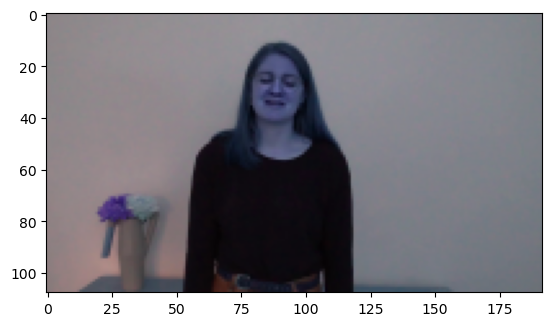

In [24]:
resize_example = cv2.resize(cv2.imread(os.path.join(train_path, 'aaeflzzhvy.mp4_0.jpg')), (0,0), fx=0.1, fy=0.1, interpolation=cv2.INTER_AREA)
print(f'Size shrunk to {resize_example.shape}')
plt.imshow(resize_example)

In [25]:
train_set = FrameDataset(device, metadata, train_path)
train_loader = DataLoader(train_set, batch_size=1024, shuffle=True, pin_memory=True)

In [26]:
val_set = FrameDataset(device, metadata, val_path)
val_loader = DataLoader(val_set, batch_size=256, shuffle=True, pin_memory=True)

In [27]:
test_set = FrameDataset(device, metadata, test_path)
test_loader = DataLoader(test_set, batch_size=256, shuffle=True, pin_memory=True)

## Autoencoder Implementation

In [28]:
class AE(nn.Module):

    def __init__(self, in_dim, hidden_dim):
        super(AE, self).__init__()

        self.in_dim = in_dim
        self.hidden = nn.Linear(np.prod(in_dim), hidden_dim)
        self.out = nn.Linear(hidden_dim, np.prod(in_dim))
        self.out.weight = nn.Parameter(self.hidden.weight.t())

    def forward(self, x):
        output_shape = x.shape
        x = torch.flatten(x, start_dim=1)
        x = torch.sigmoid(self.hidden(x))
        x = torch.sigmoid(self.out(x))
        x = torch.reshape(x, output_shape)

        return x


In [29]:
model = AE((108, 192, 3), 100).to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3)


EPOCHS = 10
train_loss_hist = []
val_loss_hist = []

best_val_loss = float('inf')
for i in range(EPOCHS):
    train_epoch_loss = 0
    
    model.train()
    counter = 0
    for ids, inputs, labels in train_loader:
        print(f'Minibatch #{counter}')
        counter +=1
        inputs = inputs.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = nn.functional.mse_loss(outputs, inputs)
        train_epoch_loss += loss.cpu().item()

        loss.backward()
        optimizer.step()
        del loss
        del inputs
        del outputs

    train_epoch_loss /= len(train_loader)
    train_loss_hist.append(train_epoch_loss)
    print(f"Loss at epoch {i}: {train_epoch_loss}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for ids, inputs, labels in val_loader:
            val_loss = 0
            inputs = inputs.to(device)

            outputs = model(inputs)

            loss = nn.functional.mse_loss(outputs, inputs)
            val_loss += loss.cpu().item()
            del loss
            del inputs
            del outputs
        
        val_loss /= len(val_loader)
        val_loss_hist.append(val_loss)
        print(f"Validation loss at epoch{i}: {val_loss}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best.pt')
        
        

Minibatch #0
Minibatch #1
Minibatch #2
Minibatch #3
Minibatch #4
Minibatch #5
Minibatch #6
Minibatch #7
Minibatch #8
Minibatch #9
Minibatch #10
Minibatch #11
Minibatch #12
Minibatch #13
Minibatch #14
Minibatch #15
Minibatch #16
Minibatch #17
Minibatch #18
Loss at epoch 0: 0.09021713623875066
Validation loss at epoch0: 0.009770078212022781
Minibatch #0
Minibatch #1
Minibatch #2
Minibatch #3
Minibatch #4
Minibatch #5
Minibatch #6
Minibatch #7
Minibatch #8
Minibatch #9
Minibatch #10
Minibatch #11
Minibatch #12
Minibatch #13
Minibatch #14
Minibatch #15
Minibatch #16
Minibatch #17
Minibatch #18
Loss at epoch 1: 0.0899866635077878
Validation loss at epoch1: 0.009154338389635086
Minibatch #0
Minibatch #1
Minibatch #2
Minibatch #3
Minibatch #4
Minibatch #5
Minibatch #6
Minibatch #7
Minibatch #8
Minibatch #9
Minibatch #10
Minibatch #11
Minibatch #12
Minibatch #13
Minibatch #14
Minibatch #15
Minibatch #16
Minibatch #17
Minibatch #18
Loss at epoch 2: 0.09028038382530212
Validation loss at epoch2:

In [30]:
torch.cuda.memory_allocated()

117636096

In [31]:
torch.cuda.empty_cache()